In [14]:
import sys
print(sys.version)
#3.8ならOK 3.6だとenvが反映されていないので


# 使用するGPUを指定
import torch
def get_device(gpu_id=-1):
    if gpu_id >= 0 and torch.cuda.is_available():
        return torch.device("cuda", gpu_id)
    else:
        return torch.device("cpu")

device = get_device(gpu_id = 1)
print(device)  # cuda:1

3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0]
cuda:1


In [15]:
# メモリ使用状況確認
import GPUtil
GPUtil.showUtilization()


| ID | GPU | MEM |
------------------
|  0 |  0% |  4% |
|  1 |  0% |  0% |


## 学習の準備

In [16]:
import numpy as np
import transformers

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import cuda
from torchvision import datasets, transforms

import time
from matplotlib import pyplot as plt

import pandas as pd
from tabulate import tabulate

In [17]:
# データの読込
# MNISTデータを取得（初回のみダウンロードが走る）
mnist_data_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor()) 
images, labels = mnist_data_train[0]
print(images)
print(labels)

"""
def load_mnist_data(trn, dl, bsize, sf):
    mnist_data = datasets.MNIST('./data', train=trn, download=dl, transform=transforms.ToTensor())
    data_loader = DataLoader(mnist_data, batch_size=bsize, shuffle=sf)

    return data_loader

data_loader = load_mnist_data(trn=False, dl=True, bsize=1, sf = False)

data_iter = iter(data_loader)
images, labels = data_iter.next()

# とりあえず先頭の内容を見てみる
print(images[0])
print(labels[0])


# 訓練データ
train_loader = load_mnist_data(train = True, dl=False, bsize=4, sf = True) #データはシャッフル
"""

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

"\ndef load_mnist_data(trn, dl, bsize, sf):\n    mnist_data = datasets.MNIST('./data', train=trn, download=dl, transform=transforms.ToTensor())\n    data_loader = DataLoader(mnist_data, batch_size=bsize, shuffle=sf)\n\n    return data_loader\n\ndata_loader = load_mnist_data(trn=False, dl=True, bsize=1, sf = False)\n\ndata_iter = iter(data_loader)\nimages, labels = data_iter.next()\n\n# とりあえず先頭の内容を見てみる\nprint(images[0])\nprint(labels[0])\n\n\n# 訓練データ\ntrain_loader = load_mnist_data(train = True, dl=False, bsize=4, sf = True) #データはシャッフル\n"

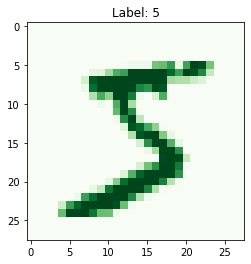

In [18]:
# 可視化
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib で1つ目のデータを可視化
for idx in range(1):
    plt.figure(idx+1)    
    npimg = images[idx].numpy()
    npimg = npimg.reshape((28, 28))
    plt.imshow(npimg, cmap='Greens')
    plt.title('Label: {}'.format(labels))

In [19]:
for data in train_loader:
    print(data[0].shape)
    print(data[0].view(-1, 28 * 28).shape)
    break


NameError: name 'train_loader' is not defined

In [20]:
#モデルの定義 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardNeuralNet(nn.Module):
    def __init__(self, drop_rate, output_size):
        super().__init__()
        self.drop = torch.nn.Dropout(drop_rate)
        self.relu = nn.ReLU()  #relu
        
        self.fc1 = nn.Linear(784, 100) # 入力層から隠れ層への設定
        self.fc2 = nn.Linear(100, output_size) # 隠れ層から出力層への設定

    def forward(self, x):
        out = x.view(-1, 28 * 28) #テンソルのリサイズ: (bsize, 1, 28, 28) --> (bsize, 784)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    

"""
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, pretrained, drop_rate, otuput_size1, output_size2):
    super().__init__()
    self.bert = BertModel.from_pretrained(pretrained, return_dict=False)
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc1 = torch.nn.Linear(768, 256)  # BERTの出力 (768次元)
    self.fc_e = torch.nn.Linear(256, otuput_size1)
    self.fc_g = torch.nn.Linear(256, output_size2)
    self.fc_e2 = torch.nn.Linear(otuput_size1+7, otuput_size1)
    
    
    self.relu = nn.ReLU()  #relu
    self.sig = nn.Sigmoid()

  def forward(self, ids, mask, labels_g):
    _, out = self.bert(ids, attention_mask=mask)
    
    
    #1層目
    #out = self.drop(out)  #dropout
    out = self.fc1(out)   # 768次元 から 256次元
    out = self.relu(out)  #Relu
    
    #3層目
    out = self.fc_e(out)  # 256次元 から ラベル数（絵文字）
    
    #4層目
    out_e = torch.cat([out, labels_g], dim=1) #tensor 結合 
    out_e = self.fc_e2(out_e)  #絵文字
    out_e = self.sig(out_e) # ラベル数+7 から ラベル数（絵文字）
    
    return out_e

  def predict(self, ids, mask, labels_g):
    _, out = self.bert(ids, attention_mask=mask)
    
    
    #1層目
    #out = self.drop(out)  #dropout
    out = self.fc1(out)   # 768次元 から 256次元
    out = self.relu(out)  #Relu
    
    #3層目
    out = self.fc_e(out)  # 256次元 から ラベル数（絵文字）
    
    #4層目
    out_e = torch.cat([out, labels_g], dim=1) #tensor 結合 
    out_e = self.fc_e2(out_e)  #絵文字
    out_e = self.sig(out_e) # ラベル数+7 から ラベル数（絵文字）
    
    return out_e, out
"""


'\n# BERT分類モデルの定義\nclass BERTClass(torch.nn.Module):\n  def __init__(self, pretrained, drop_rate, otuput_size1, output_size2):\n    super().__init__()\n    self.bert = BertModel.from_pretrained(pretrained, return_dict=False)\n    self.drop = torch.nn.Dropout(drop_rate)\n    self.fc1 = torch.nn.Linear(768, 256)  # BERTの出力 (768次元)\n    self.fc_e = torch.nn.Linear(256, otuput_size1)\n    self.fc_g = torch.nn.Linear(256, output_size2)\n    self.fc_e2 = torch.nn.Linear(otuput_size1+7, otuput_size1)\n    \n    \n    self.relu = nn.ReLU()  #relu\n    self.sig = nn.Sigmoid()\n\n  def forward(self, ids, mask, labels_g):\n    _, out = self.bert(ids, attention_mask=mask)\n    \n    \n    #1層目\n    #out = self.drop(out)  #dropout\n    out = self.fc1(out)   # 768次元 から 256次元\n    out = self.relu(out)  #Relu\n    \n    #3層目\n    out = self.fc_e(out)  # 256次元 から ラベル数（絵文字）\n    \n    #4層目\n    out_e = torch.cat([out, labels_g], dim=1) #tensor 結合 \n    out_e = self.fc_e2(out_e)  #絵文字\n    out_e = self.s

In [21]:
# loss，正解率を計算
def calculate_loss_and_accuracy(model, criterion, loader, device):
    model.eval()
    
    loss = 0.0   # loss
    total = 0    # 全体数
    correct = 0  # 正解数

    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            inputs = data[0].to(device) # 画像
            labels = data[1].to(device) # 正解ラベル
    
            # 順伝播
            outputs = model.forward(inputs)
    

            # 損失計算
            loss += criterion(outputs, labels).item()

        
            # 正解率計算
            # 絵文字
            pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
            labels = labels.cpu().numpy()  # バッチサイズの長さの正解ラベル配列
            total += len(labels)
            correct += (pred == labels).sum().item()  #一致するものを計算
        
    return loss/len(loader), correct/total, pred, outputs  # loss，正解率，予測ラベル，出力


#モデルの学習を実行し、損失・正解率のログを返す
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, parallel_frag, device=None):
    
    # デバイスの指定
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) 
    dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

    # 学習
    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for data in dataloader_train:
            # デバイスの指定
            inputs = data[0].to(device) # 画像
            labels = data[1].to(device) # 正解ラベル

            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # マルチタスク学習 順伝播 + 誤差逆伝播 + 重み更新 
            outputs = model.forward(inputs)
            loss  = criterion(outputs, labels)
            
            #lossを逆伝播
            loss.backward()
            optimizer.step()

        # 損失と正解率の算出
        loss_train, acc_train, pred, outputs = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
        loss_valid, acc_valid, pred, outputs = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        # チェックポイントの保存
        if epoch < 20:
            if parallel_frag: 
                torch.save({'epoch': epoch, 'model_state_dict': model.module.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
            else:
                torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        # 終了時刻の記録
        e_time = time.time()

        # ログを出力
        print(f'epoch: {epoch + 1}')
        print(f'loss_tr: {loss_train:.4f}, acc_tr: {acc_train:.4f}, loss_val: {loss_valid:.4f}, acc_val: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 
    
    return {'train': log_train, 'valid': log_valid} ,pred, outputs

In [10]:
# パラメータの設定
DROP_RATE = 0.1
OUTPUT_SIZE_1 = 10 #データアセットのラベル数
BATCH_SIZE = 4096
NUM_EPOCHS = 20
LEARNING_RATE = 4e-2
parallel_frag = False #GPU２枚使用

# モデルの定義
model = FeedForwardNeuralNet(DROP_RATE, OUTPUT_SIZE_1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr= LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'
if parallel_frag:
    print("hi")
    model = torch.nn.DataParallel(model) # make parallel
    torch.backends.cudnn.benchmark = True
    
# モデルの学習
log, labels, outputs = train_model(mnist_data_train, mnist_data_test, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, parallel_frag, device=device)


epoch: 1
loss_tr: 0.4483, acc_tr: 0.8658, loss_val: 0.4321, acc_val: 0.8673, 4.8382sec
epoch: 2
loss_tr: 0.2351, acc_tr: 0.9304, loss_val: 0.2275, acc_val: 0.9308, 4.6023sec
epoch: 3
loss_tr: 0.1687, acc_tr: 0.9504, loss_val: 0.1676, acc_val: 0.9485, 4.6439sec
epoch: 4
loss_tr: 0.1361, acc_tr: 0.9598, loss_val: 0.1441, acc_val: 0.9562, 4.6101sec
epoch: 5
loss_tr: 0.1158, acc_tr: 0.9652, loss_val: 0.1332, acc_val: 0.9593, 4.6229sec
epoch: 6
loss_tr: 0.1007, acc_tr: 0.9700, loss_val: 0.1201, acc_val: 0.9640, 4.6122sec
epoch: 7
loss_tr: 0.0875, acc_tr: 0.9740, loss_val: 0.1176, acc_val: 0.9652, 4.6771sec
epoch: 8
loss_tr: 0.0779, acc_tr: 0.9776, loss_val: 0.1119, acc_val: 0.9655, 4.6235sec
epoch: 9
loss_tr: 0.0697, acc_tr: 0.9793, loss_val: 0.1081, acc_val: 0.9676, 4.6136sec
epoch: 10
loss_tr: 0.0608, acc_tr: 0.9828, loss_val: 0.1085, acc_val: 0.9672, 4.6609sec
epoch: 11
loss_tr: 0.0549, acc_tr: 0.9841, loss_val: 0.1050, acc_val: 0.9682, 4.6200sec
epoch: 12
loss_tr: 0.0531, acc_tr: 0.9842

絵文字


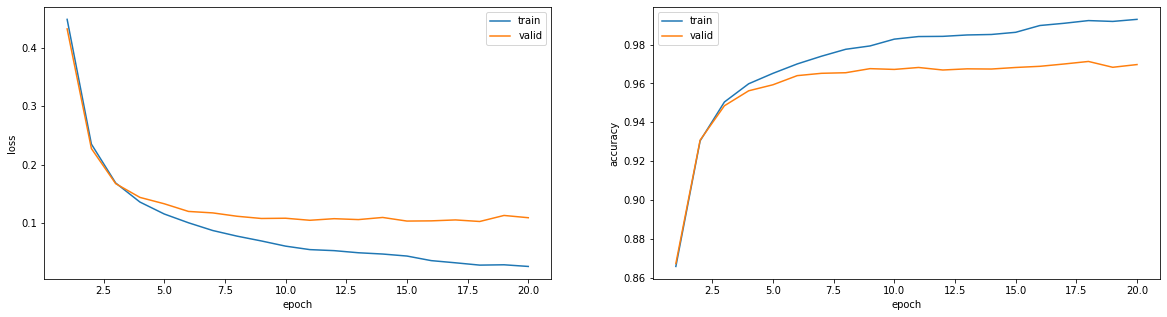

In [11]:
# ログの可視化 (考慮なし) 500
print("絵文字")
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()            

In [13]:
#チェックポイントのロード
CHECK_POINT = "checkpoint18.pt"
# パラメータの設定
DROP_RATE = 0.1
OUTPUT_SIZE_1 = 10 #データアセットのラベル数
BATCH_SIZE = 4096
NUM_EPOCHS = 20
LEARNING_RATE = 4e-2
parallel_frag = False #GPU２枚使用

# モデルの定義
model = FeedForwardNeuralNet(DROP_RATE, OUTPUT_SIZE_1)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'
if parallel_frag:
    print("hi")
    model = torch.nn.DataParallel(model) # make parallel
    torch.backends.cudnn.benchmark = True
    
optimizer = torch.optim.AdamW(params=model.parameters(), lr= LEARNING_RATE)
 
checkpoint = torch.load(CHECK_POINT)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
model.eval()

FeedForwardNeuralNet(
  (drop): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [67]:
# test の正解率
dataloader_test = DataLoader(mnist_data_test, batch_size=BATCH_SIZE, shuffle=False)
loss_valid, acc_valid, pred, outputs = calculate_loss_and_accuracy(model, criterion, dataloader_test, device)
print(loss_valid, acc_valid)

RuntimeError: Tensor for 'out' is on CPU, Tensor for argument #1 'self' is on CPU, but expected them to be on GPU (while checking arguments for addmm)

In [ ]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

In [21]:
from sklearn.metrics import recall_score, precision_score, f1_score # 読み込んでおく
import numpy as np

def calculate_loss_and_accuracy2(model, loader, device, criterion=None):
  """ 損失・正解率を計算"""
  model.to(device)
  model.eval()
  loss = 0.0
  total = 0
  all_correct = 0
  y_true = []
  y_pred = []
    
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels_e = data['labels_e'].to(device)
      labels_g = data['labels_g'].to(device)

      # 順伝播
      outputs_e, outputs_g = model(ids, mask)
    
      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels_e).item()
        

      # 正解率計算  
      total += len(labels_e)
      
      opt = torch.argmax(outputs, dim=-1).cpu().tolist() # バッチサイズの長さの予測ラベル配列
      y_pred.append(opt[0])
    
      lbl = torch.argmax(labels_e, dim=-1).cpu().tolist() # バッチサイズの長さの正解ラベル配列
      y_true.append(lbl[0])
    
      if opt == lbl:
        all_correct += 1 #完全正解率
    
        
        
            
  return all_correct / total, y_true, y_pred



def seikairitu(model, dataloader, device):
    all_correct, y_true, y_pred = calculate_loss_and_accuracy2(model, dataloader, device)

        
    f1_score_macro = f1_score(y_true=y_true, y_pred=y_pred, average="macro")
    f1_score_micro = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
    
    print("All:",all_correct,"f1_score_macro",f1_score_macro,"f1_score_micro:",f1_score_micro)
    return y_true, y_pred
    
    
    
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

print("train")
#y_true, y_pred = seikairitu(model, dataloader_train, device)
print("valid")
y_true, y_pred = seikairitu(model, dataloader_valid, device)
print("test")
#seikairitu(model, dataloader_test, device)


train
valid
All: 0.053125 f1_score_macro 0.01646866332753706 f1_score_micro: 0.053125
test


In [40]:
dataloader_train = DataLoader(dataset_train, batch_size=256, shuffle=True)
dataloader_train["labels_e"]

TypeError: 'DataLoader' object is not subscriptable

In [23]:
y_pred

[14,
 14,
 18,
 14,
 14,
 14,
 14,
 19,
 14,
 18,
 19,
 14,
 18,
 19,
 18,
 19,
 14,
 18,
 19,
 14,
 15,
 14,
 18,
 14,
 14,
 19,
 15,
 14,
 14,
 14,
 18,
 18,
 14,
 18,
 18,
 18,
 15,
 19,
 18,
 14,
 14,
 19,
 19,
 14,
 19,
 14,
 15,
 18,
 15,
 18,
 18,
 18,
 18,
 18,
 14,
 14,
 18,
 14,
 18,
 14,
 18,
 14,
 14,
 15,
 18,
 14,
 14,
 14,
 18,
 14,
 18,
 14,
 15,
 19,
 18,
 15,
 15,
 19,
 15,
 18,
 15,
 14,
 14,
 19,
 14,
 18,
 14,
 19,
 19,
 19,
 19,
 14,
 19,
 14,
 14,
 14,
 19,
 19,
 19,
 14,
 14,
 18,
 14,
 18,
 14,
 14,
 14,
 14,
 18,
 14,
 14,
 19,
 14,
 19,
 19,
 14,
 14,
 18,
 14,
 18,
 14,
 19,
 14,
 19,
 15,
 14,
 14,
 19,
 18,
 19,
 14,
 19,
 14,
 18,
 18,
 14,
 14,
 15,
 19,
 14,
 14,
 18,
 14,
 19,
 14,
 14,
 14,
 14,
 18,
 18,
 18,
 18,
 19,
 19,
 18,
 14,
 18,
 19,
 15,
 14,
 15,
 18,
 14,
 19,
 14,
 14,
 19,
 19,
 19,
 19,
 19,
 14,
 19,
 14,
 14,
 14,
 19,
 19,
 14,
 14,
 14,
 18,
 14,
 14,
 14,
 14,
 14,
 14,
 18,
 14,
 14,
 19,
 14,
 19,
 18,
 14,
 14,
 18,
 14,
 15,


In [29]:
hyou = [[0 for _ in range(len(categories))]for _ in range(len(categories))]
print("y_true")
for i in range(len(y_pred)):
    hyou[y_pred[i]][y_true[i]] += 1
#for i in range(len(categories)):

y_true


In [31]:
hyou
h = pd.DataFrame(hyou)
h

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train
All: 0.8457886751823032 f1_score_macro 0.8942904193518334 f1_score_micro: 0.895498732866233
valid
All: 0.7255285826155051 f1_score_macro 0.7555964009662386 f1_score_micro: 0.7654989919354839
test
All: 0.731175779720736 f1_score_macro 0.748409030406055 f1_score_micro: 0.7588867805186591

In [ ]:
print("All:",all_correct, "f1_score_macro",f1_score_macro,"f1_score_micro:",f1_score_micro)

In [ ]:
#こっから下はよび
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算，絵文字のみ"""
  model.eval()
    
  emoji_loss = 0.0
  gen_loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels_e = data['labels_e'].to(device)

      # 順伝播
      outputs = model.forward(ids, mask)
    

      # 損失計算
      emoji_loss += criterion(outputs, labels_e).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels_e, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()

  return emoji_loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None, lambda_gen = 0):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels_e = data['labels_e'].to(device)
      labels_g = data['labels_g'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # マルチタスク学習 順伝播 + 誤差逆伝播 + 重み更新 
      outputs_e, outputs_g = model.forward(ids, mask)
      loss_e  = criterion(outputs_e, labels_e)
      loss_g  = criterion(outputs_g, labels_g)
      #lossを結合
      loss = loss_e + lambda_gen * loss_g 
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    if epoch < 30:
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')


    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_tr: {loss_train:.4f}, acc_tr: {acc_train:.4f}, loss_val: {loss_valid:.4f}, acc_val: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

  return {'train': log_train, 'valid': log_valid}

In [20]:
# シングルタスクモデルの定義 ver.1
class BERTClass(torch.nn.Module):
  def __init__(self, pretrained, drop_rate, otuput_size1, output_size2):
    super().__init__()
    self.bert = BertModel.from_pretrained(pretrained, return_dict=False)
    self.drop = torch.nn.Dropout(drop_rate)
    
    #主タスク 絵文字
    self.emoji_fc = nn.Sequential(  # 絵文字用の全結合層
      nn.Dropout(drop_rate),
      nn.Linear(768, 512),
      nn.ReLU(),
        
      nn.Dropout(drop_rate),
      nn.Linear(512, 256),
      nn.ReLU(),
        
      nn.Dropout(drop_rate),
      nn.Linear(256, 128),
      nn.ReLU(),
        
      nn.Linear(128, otuput_size1),
      nn.Sigmoid()
        
    )
    

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask)
    out_e = self.emoji_fc(out)
    
    return out_e

  def predict(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask)
    out_e = self.emoji_fc(out)
    
    return out_e

In [28]:
# 正解率の算出

device = "cuda:1"
model = model.to(device)

dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)


k1 = calculate_loss_and_accuracy(model, dataloader_train, device)
k2 = calculate_loss_and_accuracy(model, dataloader_valid, device)
k3 = calculate_loss_and_accuracy(model, dataloader_test, device)

print(f'loss（学習データ）：{k1[0]:.3f}',f'完全正解率（学習データ）：{k1[1]:.3f}',f'部分正解率（学習データ）：{k1[2]:.3f}')
print(f'loss（検証データ）：{k2[0]:.3f}',f'完全正解率（検証データ）：{k2[1]:.3f}',f'部分正解率（検証データ）：{k2[2]:.3f}')
print(f'loss（評価データ）：{k3[0]:.3f}',f'完全正解率（評価データ）：{k3[1]:.3f}',f'部分正解率（評価データ）：{k3[2]:.3f}')

TypeError: calculate_loss_and_accuracy() missing 1 required positional argument: 'device'